In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
from google.colab import drive
drive.mount('/content/drive')
from datetime import date
import time
from sklearn.model_selectQion import train_test_split
import os
import math
from math import radians
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from scipy.optimize import curve_fit
import pylab
import math

In [114]:
# 데이터 불러오기

raw_data = pd.read_csv('/content/drive/MyDrive/submission_paramtry5.csv')
submission = pd.read_csv('/content/drive/MyDrive/Jupyter/raw_data/sample_submission.csv')

In [115]:
dataset = raw_data.copy()

In [116]:
# 만약에 안 불러오고 LGBM 끝에 붙인다면, 적당히 수정해서 여기부터 돌리면 됨.
# 일단 input은 다음과 같은 모양(인덱스, 칼럼으로 만들고 시작하기를 추천, 안 그러면 for 문에서 오류 발생)

dataset.set_index('id', inplace = True)
dataset

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,3.253672e-34,3.238340e-34,0.051453,0.000253
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,3.253672e-34,3.238340e-34,0.049170,0.000000
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,3.253672e-34,3.238340e-34,0.047825,0.002594
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,3.253672e-34,3.238340e-34,0.051447,0.000000
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,3.253672e-34,3.238340e-34,0.050620,0.000000
...,...,...,...,...,...,...,...,...,...
80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,3.253050e-34,3.248526e-34,0.016446,0.076380
80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,3.253050e-34,3.248526e-34,0.010265,0.000000
80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,3.253050e-34,3.248526e-34,0.001963,0.033007


In [117]:
# columns_IDA는 상하로 맞춰줌
# rows_IDA는 좌우로 맞춰줌
# 상하 > 좌우 & 좌우 > 상하를 비교한 결과 좌우로 먼저 맞춘 다음에 상하를 맞추는 것이 쬐------끔 좋은 결과를 보임.

# 그래서 rows_IDA 먼저 하고 columns_IDA 추천


def columns_IDA(dataset):
  dataset2 = pd.DataFrame()
  for j in range(0,9):
    new_val = []
    for m in range(1, int(raw_data.shape[0]/48)+1):
      temp = dataset.iloc[48*(m-1):48*m,j].values

      strt = 0
      endd = 0
      k = 0

      for i in range(len(temp)):
        if temp[i] > k and k ==0 and i > 10 and i < 24:
          strt = i
        elif temp[i] < k and temp[i] == 0 and i > 24 and i < 40:
          endd = i
        k = temp[i]
      if strt != 0:
        bf = temp[:strt+1]
        y = temp[strt+1:endd-1]
        af = temp[endd-1:]
        # bf = temp[:strt]
        # y = temp[strt:endd]
        # af = temp[endd:]

        x = np.array([i for i in range(len(y))])
        fit_t = np.polyfit(x,y,5)

        for i in x:
          fit1 = fit_t[0]*x**5 + fit_t[1]*x**4 + fit_t[2]*x**3 + fit_t[3]*x**2 + fit_t[4]*x + fit_t[5]
      # fit1 = fit_t[0]*x**4 + fit_t[1]*x**3 + fit_t[2]*x**2 + fit_t[3]*x + fit_t[4]
      # fit1 = fit_t[0]*x**2 + fit_t[1]*x + fit_t[2]

        revised = np.concatenate((bf, fit1, af), axis=0)
      elif strt == 0:
        revised = temp
      new_val.extend(list(revised))
    k = pd.DataFrame(new_val)
    dataset2 = pd.concat([dataset2, k], axis = 1)
  return dataset2

def f(x, a,b,c, d):
  b = b**2
  y = 1/3 * b * x**3 - a*b *x**2 + (a**2*b + b*c**2)*x + d
  # y = a*(x-12*a) * x **2 + c
  # y = a*x**2 + b
  return y

def rows_IDA(dataset):
  revised = pd.DataFrame()
  for i in range(dataset.shape[0]):
    y = dataset.iloc[i,:].values
    x = np.array([i for i in range(1, 10)])

    if list(y).count(0) <= 6 :
      popt, pcov = curve_fit(f, x, y, maxfev = 999990000)
      yfit = f(x, *popt)
      revised = pd.concat([revised, pd.DataFrame(yfit).transpose()], axis = 0)
    else:
      revised = pd.concat([revised, pd.DataFrame(y).transpose()], axis = 0)
    if i % 1000 == 0:
      print(i, '/7776')
  return revised

In [118]:
def not_minus(dataset):
  for i in range(0, len(dataset.index)):
    for j in range(0, len(dataset.columns)):
      K = dataset.iloc[i,j]
      if K < 0.1:
        dataset.iloc[i,j] = 0
  return dataset

def not_dec(dataset):
  for i in range(0, len(dataset.index)):
    for j in range(0, len(dataset.columns) - 1):
      K = dataset.iloc[i,j]
      T = dataset.iloc[i,j+1]
      if K > 0 and T == 0:
        dataset.iloc[i,j] = 0
  return dataset

In [119]:
dataset2 = not_minus(dataset)
dataset2 = pd.DataFrame(dataset2.values, columns = dataset.columns, index = dataset.index)


In [120]:
dataset2 = not_dec(dataset2)
dataset2 = pd.DataFrame(dataset2.values, columns = dataset.columns, index = dataset.index)

In [121]:
test = rows_IDA(dataset)
test = pd.DataFrame(test.values, columns = dataset.columns, index = dataset.index)

0 /7776


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1000 /7776
2000 /7776
3000 /7776
4000 /7776
5000 /7776
6000 /7776
7000 /7776


In [122]:
dataset2 = not_minus(test)
dataset3 = pd.DataFrame(dataset2.values, columns = dataset.columns, index = dataset.index)

In [123]:
# submission2 = pd.DataFrame(submission.iloc[:,0])
dataset4 = columns_IDA(dataset3)
# submission3 = pd.concat([submission2, dataset2], axis = 1)
dataset5 = pd.DataFrame(dataset4.values, columns = dataset.columns, index = dataset.index)

In [124]:
submission2 = pd.DataFrame(not_minus(dataset5).values, columns = dataset.columns, index = dataset.index)

In [125]:
dataset3 = pd.DataFrame(rows_IDA(submission2).values, columns = dataset.columns, index = dataset.index)
submission3 = pd.DataFrame(not_minus(dataset3).values, columns = dataset.columns, index = dataset.index)
submission3 = pd.DataFrame(not_dec(submission3).values, columns = dataset.columns, index = dataset.index)

0 /7776


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1000 /7776
2000 /7776
3000 /7776
4000 /7776
5000 /7776
6000 /7776
7000 /7776


In [126]:
for i in range(162):
  a = i *48
  a_a = a + 10
  b = (i+1) * 48
  a_b = a + 39
  submission3.iloc[a: a_a, :] = 0
  submission3.iloc[a_b:b, :] = 0

In [127]:
submission3.head(50)

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [128]:
submission3.to_csv('sub_0.csv')
!cp sub_0.csv "drive/My Drive/"

In [129]:
### 아래는 시각화

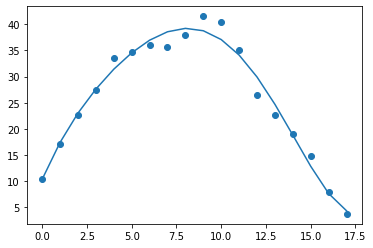

In [130]:
dataset = raw_data.copy()
dataset2 = pd.DataFrame()

m = 5
j = 1

new_val = []

temp = dataset.iloc[48*(m-1):48*m,j].values

strt = 0
endd = 0
k = 0

for i in range(len(temp)):
  if temp[i] > k and k ==0 and i < 24:
    strt = i
  elif temp[i] < k and temp[i] == 0 and i > 24:
    endd = i
  k = temp[i]

bf = temp[:strt+1]
y = temp[strt+1:endd-1]
af = temp[endd-1:]
# bf = temp[:strt]
# y = temp[strt:endd]
# af = temp[endd:]

x = np.array([i for i in range(len(y))])
fit_t = np.polyfit(x,y,5)

for i in x:
  fit1 = fit_t[0]*x**5 + fit_t[1]*x**4 + fit_t[2]*x**3 + fit_t[3]*x**2 + fit_t[4]*x + fit_t[5]

plt.scatter(x,y)
plt.plot(x,fit1)
plt.show()

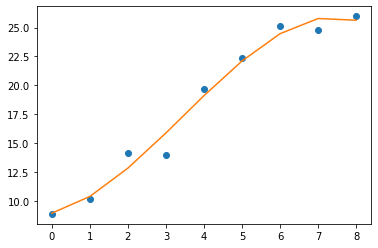

In [131]:
# yexact =  (1 + math.erf((x-mu)/alpha * math.sqrt(2))) * ya
y = dataset.iloc[18,1:].values
x = np.array([i for i in range(len(y))])

y = np.array(list(y))

def f(x, a,b,c, d):
  y = 1/3 * b * x**3 - a*b *x**2 + (a**2*b + c**2)*x + d
  # y = a*(x-12*a) * x **2 + c
  # y = a*x**2 + b
  return y

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

# Unweighted fit
popt, pcov = curve_fit(f, x, y, maxfev = 999990000)
yfit = f(x, *popt)

pylab.plot(x, y, 'o', label='Noisy data')
pylab.plot(x, yfit, label='Unweighted fit')
pylab.show()